## Run LAS

In [1]:
#Build Molecule
import numpy as np
from pyscf import gto, scf, lib, mcscf
import math
import time
import os
from tools import sign_control, util
from systems.ethchain import EthChain_ET

geom = EthChain_ET(8,dist=2.5,c_dist=1.4,fn="logs/ethylene_chain_et.log")
las = geom.make_las_state_average()

#Build LAS states
print("Initiating LAS Model Space...")
start = time.perf_counter()
las.lasci_(lroots=geom.lroots) #Must put in lroots
las.ci = sign_control.fix_sign(las)
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")
las.dump_spaces()

#Run LASSI
print("Running LASSI...")
start = time.perf_counter()
from mrh.my_pyscf import lassi
lsi = lassi.LASSI(las)
energies_lassi, civecs_lassi = lsi.kernel(lroots=geom.lroots)
# energies_lassi, civecs_lassi = lsi.kernel()
civecs_lassi = lsi.get_sivec_vacuum_shuffle(state=0)
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")

/home/king1305/Apps/pyscf/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


overwrite output file: logs/ethylene_chain_et.log
Initiating LAS Model Space...
Done. Time elapsed: 2.140437186928466 seconds
Running LASSI...
Done. Time elapsed: 1.4787411498837173 seconds


## Plotting

In [11]:
from scipy import linalg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tools.bandh import make_h
sns.set()

def evolve(H,t=10000,deltat=0.01,startin=1):
    c0 = np.eye(H.shape[0])[:,startin]
    cs = [c0]
    c = c0
    tstep = 0.01
    for i in range(t):
        U = linalg.expm(-(1j)*tstep*H) #evolution
        c = U @ c
        cs += [c]
    cs = np.vstack(cs)
    assert(np.allclose(np.real((cs*cs.conj()).sum(axis=1)),np.ones(cs.shape[0])))
    return cs

def c_to_charges(c,las_charges):
    p = np.real(c * c.conj())
    assert(np.allclose(p.sum(),1,atol=1e-4))
    charges = las_charges #cut out gs
    charges = (charges * p[:,None]).sum(axis=0)
    return charges

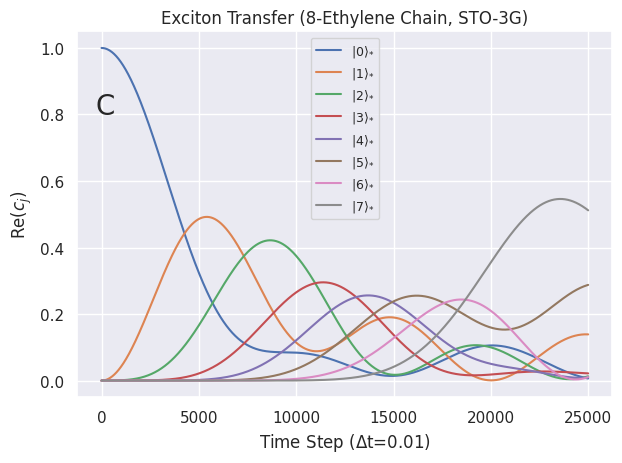

In [28]:
H = make_h(civecs_lassi,energies_lassi,plot=False,prnt=False)
idx = np.sort(np.argsort(np.diag(H))[:geom.nfrags+1])
H = H[np.ix_(idx,idx)] #Evolved in just space of the excitons
cs = evolve(H,startin=1,t=25000)
cs2 = cs * cs.conj()
df = pd.DataFrame(cs2[:,1:]) #cut out ground state
for col in df.columns:
    x = df.index
    y = np.real(df[col])
    plt.plot(x,y,label = f"|{col}⟩" + "$_{*}$")
# plt.legend(bbox_to_anchor=(1,1))
plt.legend(loc="upper center",fontsize=9)
plt.xlabel("Time Step ($\Delta$t=0.01)")
plt.ylabel("Re($c_j$)")
plt.title("Exciton Transfer (8-Ethylene Chain, STO-3G)")
plt.annotate("C",(-300,0.8),fontsize=20)
plt.tight_layout()
plt.savefig("figures/excoeff.png",dpi=500)

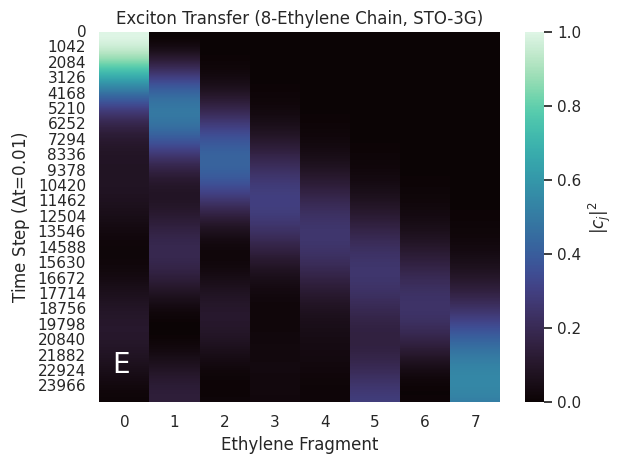

In [30]:
sns.heatmap(np.real(cs[:,1:]*cs[:,1:].conj()),cmap="mako",cbar_kws={'label': '$|c_j|^2$'})
plt.ylabel("Time Step ($\Delta$t=0.01)")
plt.xlabel("Ethylene Fragment")
plt.title("Exciton Transfer (8-Ethylene Chain, STO-3G)")
plt.annotate("E",(0.25,23000),fontsize=20,c="white")
plt.tight_layout()
plt.savefig("figures/exmatrix.png",dpi=500)

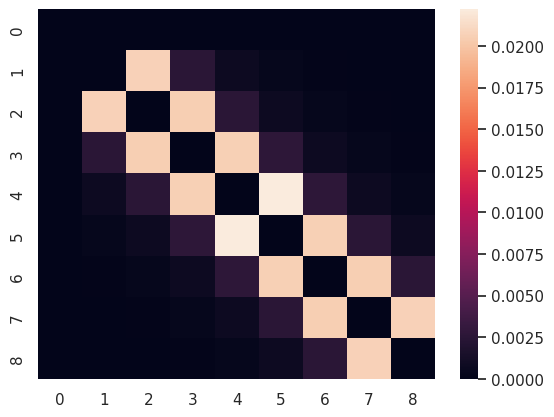

In [24]:
H = make_h(civecs_lassi,energies_lassi,plot=False,prnt=False)
idx = np.sort(np.argsort(np.diag(H))[:geom.nfrags+1])
H = H[np.ix_(idx,idx)]
H = H - np.diag(np.diag(H))
sns.heatmap(H)
plt.savefig("figures/ex_hamiltonian_nodiag.png",dpi=500)

[6.43057127 6.4298551  6.42984064 6.42984602 6.42987088 6.42987088
 6.42984602 6.42984064 6.4298551 ]


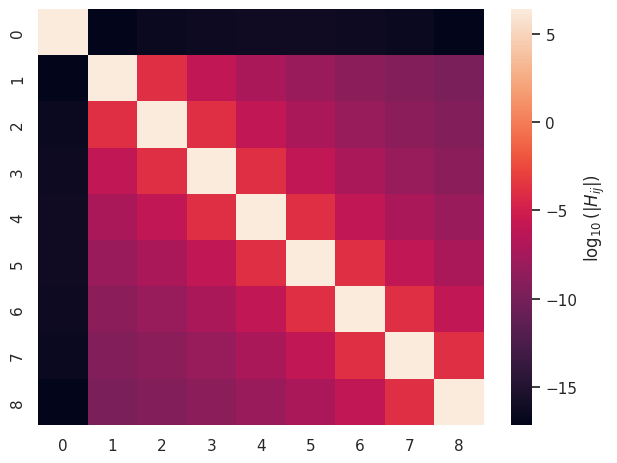

In [25]:
H = make_h(civecs_lassi,energies_lassi,plot=False,prnt=False)
idx = np.sort(np.argsort(np.diag(H))[:geom.nfrags+1])
H = H[np.ix_(idx,idx)]
for i in range(H.shape[0]):
    H[i][np.where(H[i] != 0)] = np.log(np.abs(H[i][np.where(H[i] != 0)]))
    H[i][np.where(H[i] == 0)] = -20
print(np.diag(H))
sns.heatmap(H,cbar_kws={'label': "$\log_{10}(|H_{ij}|)$"})
plt.tight_layout()
plt.savefig("figures/ex_hamiltonian_log.png",dpi=500)

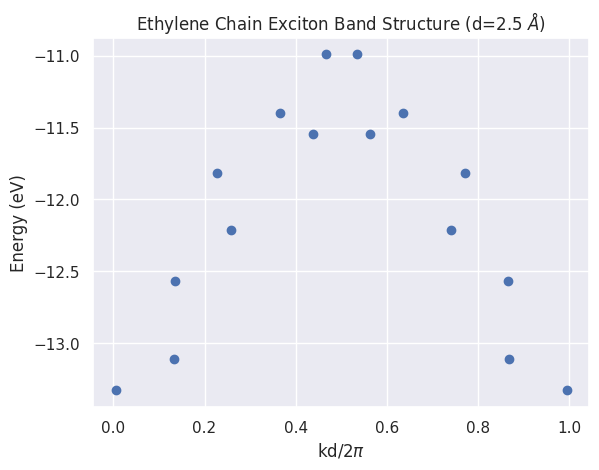

In [26]:
#Exciton Band Structure
from tools.bandh import calc_disp, copy_bz
H = make_h(civecs_lassi,energies_lassi,plot=False,prnt=False)
gs_e = H[0,0]
idx = np.sort(np.argsort(np.diag(H))[:geom.nfrags+1])
H = H[np.ix_(idx,idx)]
H = H[1:,1:]
energies,civecs = np.linalg.eigh(H)
k = calc_disp(civecs)
energies = gs_e - energies
energies,k = copy_bz(energies,k)
hartree_to_ev = 27.2114
energies *= hartree_to_ev
plt.scatter(k,energies)
plt.ylabel("Energy (eV)")
plt.xlabel("kd/2$\pi$")
plt.title("Ethylene Chain Exciton Band Structure (d=2.5 $\AA$)")
plt.savefig("figures/ethylene_exciton_band.png",dpi=500)